<a href="https://colab.research.google.com/github/ifyyy10/Cartoonify/blob/main/Breast_Cancer_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT ALL LIBRARIES AND MOUNT GOOGLE DRIVE

In [1]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=1fd0bf934ec7946bcd4804f687375f5a0b6d8299b0cf3bf9de6b9ff94c7d8db4
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
# import all libraries
import os
import wget
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


LOAD DATASET

In [3]:
# Define paths
base_dir = '/content/drive/My Drive/Dataset_BUSI_with_GT'  # Update with your dataset path
unknown_folder = os.path.join(base_dir, 'unknown')

POPULATE UNKNOWN FOLDER WITH RANDOM IMAGES

In [ ]:
## populate unknown folder with random images

# Define how many random images you want to download
num_images = 300  # Set this to the number of random images you need

# Download random images from Lorem Picsum
for i in range(num_images):
    image_url = f"https://picsum.photos/200/300?random={i}"  # 200x300 random image
    image_path = os.path.join(unknown_folder, f'random_image_{i}.jpg')
    wget.download(image_url, image_path)

print(f'{num_images} random images downloaded into the unknown folder.')

KeyboardInterrupt: 

PRE-PROCESS DATA

In [4]:
# Define Image Dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32


# Create an ImageDataGenerator with a 20% validation split (define preprocessing strategy)
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


# Load and preprocess data

# Training generator
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Validation generator
validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 1743 images belonging to 4 classes.
Found 435 images belonging to 4 classes.


BUILD TRANSFER LEARNING MODEL USING VGG16 PRE-TRAINED LAYERS

In [5]:
# Define the input shape
input_shape = (224, 224, 3)
inputs = Input(shape=input_shape)

# Load the VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)

# Freeze the base model layers (so they don't get trained)
base_model.trainable = False

# Add custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation='softmax')(x)  # 4 output classes

# Create the model
model = models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,3

 Total params: 14,847,044 (56.64 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

  TRAIN THE MODEL

In [6]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 1001s 16s/step - accuracy: 0.4698 - loss: 1.2340 - val_accuracy: 0.6575 - val_loss: 0.8364
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 43s 689ms/step - accuracy: 0.7010 - loss: 0.8034 - val_accuracy: 0.7770 - val_loss: 0.6920
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 46s 736ms/step - accuracy: 0.7525 - loss: 0.6579 - val_accuracy: 0.7862 - val_loss: 0.6309
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 81s 734ms/step - accuracy: 0.8028 - loss: 0.5408 - val_accuracy: 0.7770 - val_loss: 0.5709
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 45s 752ms/step - accuracy: 0.8175 - loss: 0.4844 - val_accuracy: 0.7908 - val_loss: 0.5511
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 82s 753ms/step - accuracy: 0.8224 - loss: 0.4505 - val_accuracy: 0.7908 - val_loss: 0.5295
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 82s 717ms/step - accuracy: 0.8297 - loss: 0.4481 - val_accuracy: 0.7954 - val_loss: 0.4824
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 45s 757ms/step - accuracy: 0.8462 - loss: 0.4122 - val_accuracy: 0.809

SAVE TRAINED MODEL

In [7]:
# Save the model after training
model.save('/content/drive/My Drive/breast_cancer_classifier_corrected.h5')

PLOT TRAINING VS VALIDATION

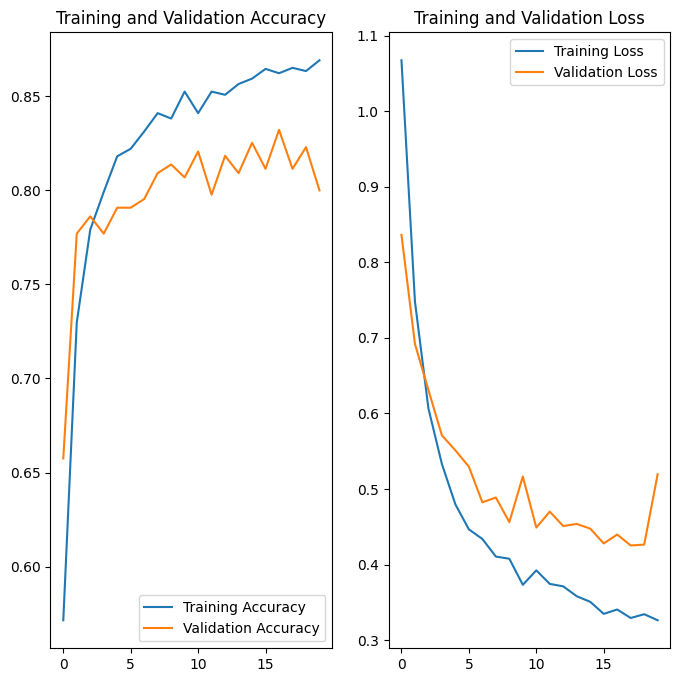

In [9]:
# Plot training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


CREATE GUI FOR TESTING MODEL

In [11]:
# Load the model for prediction
model = load_model('/content/drive/MyDrive/breast_cancer_classifier_corrected.h5')

# Function for prediction
def classify_image(image_path):

    img = Image.open(image_path).resize((224, 224))
    img_array = np.expand_dims(np.array(img) / 255.0, axis=0)
    prediction = model.predict(img_array)
    classes = ['benign', 'malignant', 'normal', 'unknown']
    return classes[np.argmax(prediction)]

# Create widgets
file_upload = widgets.FileUpload(accept='image/*', multiple=False)
output_label = widgets.Label(value="Upload an image for classification")
classify_button = widgets.Button(description="Classify Image")

# Button click event
def on_classify_button_click(b):
    for filename, file_info in file_upload.value.items():
        with open(filename, 'wb') as f:
            f.write(file_info['content'])
        result = classify_image(filename)
        output_label.value = f"Prediction: {result}"

classify_button.on_click(on_classify_button_click)

# Display widgets
display(file_upload, classify_button, output_label)


FileUpload(value={}, accept='image/*', description='Upload')

Button(description='Classify Image', style=ButtonStyle())

Label(value='Upload an image for classification')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
